In [262]:
from urllib.request import urlopen
import json
from datetime import datetime
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd
%matplotlib inline

In [188]:
def get_all_article(result=[],article_id=None,sort_key=None):
    # api url
    if not(article_id) and not(sort_key):
        article_api   = "https://alis.to/api/articles/recent?limit=100"
    else:
        article_api   = "https://alis.to/api/articles/recent?limit=100&article_id=%s&sort_key=%s" % (article_id,sort_key)
    # データ取得
    raw_article_data  = urlopen(article_api).read().decode("utf-8") 
    json_article_data = json.loads(raw_article_data)                    
    articles_data     = json_article_data["Items"]
    result.extend(articles_data)
    # ループ終了のチェック
    if 'LastEvaluatedKey' not in json_article_data.keys():
        # ループ終了
        result = pd.DataFrame(result)
        result = result.dropna()
        result["published_at"] = result["published_at"].map(lambda x:datetime.fromtimestamp(int(x)))
        return pd.DataFrame(result)
    else:
        # ループ継続
        # 次のデータ取得用パラメータ
        LastEvaluatedKey  = json_article_data["LastEvaluatedKey"]
        article_id        = LastEvaluatedKey["article_id"]
        sort_key          = LastEvaluatedKey["sort_key"]
        return get_all_article(result,article_id,sort_key)

In [107]:
# 公開時間・lile数を取得
def get_date_and_like(article_data):
    data              = defaultdict(lambda:{"like":0,"count":0})        
    likes_api         = "https://alis.to/api/articles/%s/likes"  
    for article in article_data.iterrows():
        article_id          = article[1]["article_id"]                                  
        raw_like_data       = urlopen(likes_api % article_id).read().decode("utf-8") 
        json_like_data      = json.loads(raw_like_data)                              
        like                = json_like_data["count"]                                
        hour                = article[1]["published_at"].hour                 
        data[hour]["like"]  += like                                                 
        data[hour]["count"] += 1
    return data


In [193]:
# グラフ用にデータを整形
def adjust_data(data):
    x      = []              
    mean   = []
    for k,v in data.items():
        x.append(k)
        mean.append(v["like"]/v["count"])
    return x,mean
    

In [265]:
# グラフの作成
def show_graph(data):
    x,mean = adjust_data(data)
    plt.bar(x,mean,color="lightblue")               
    plt.title("hourly earned like") 
    plt.xlabel("published time")    
    plt.ylabel("mean earned like") 
    plt.xticks(range(0,25,3))
    y_max = max(mean)
    y_min = min(mean)
    diff = (y_max - y_min) * 0.1
    plt.ylim(y_min - diff,y_max + diff)
    plt.show()                    

In [177]:
def is_holyday(date):
    if date.weekday() == 5 or date.weekday() == 6:
        return True
    else:
        return False

In [189]:
articles = get_all_article()
holyday_articles = articles[articles["published_at"].map(is_holyday)]
weekday_articles = articles[articles["published_at"].map(lambda x:not(is_holyday(x)))]
weekday_data = get_date_and_like(weekday_articles)
holyday_data = get_date_and_like(holyday_articles)
x,weekday_mean = adjust_data(weekday_data)
x,holyday_mean = adjust_data(holyday_data)

In [261]:
x_ = [h+0.3 for h in x]

(14.56265091410831, 34.15164711969644)

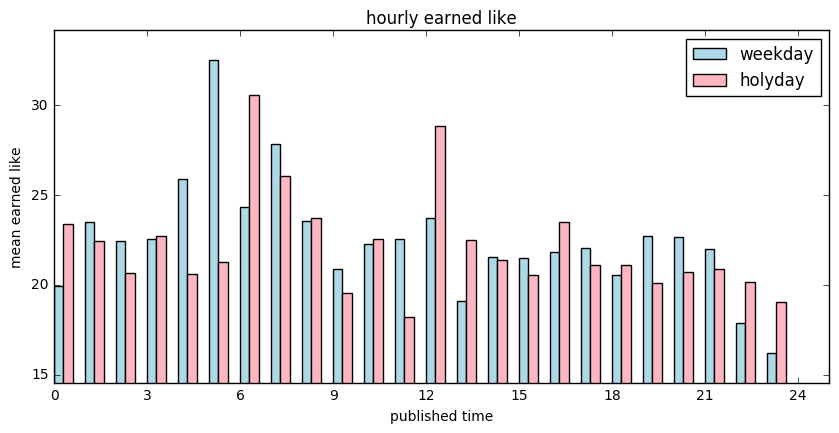

In [260]:
fig = plt.figure(figsize=(10,10),dpi=200)
ax = fig.add_subplot(2,1,1)
ax.bar(x,weekday_mean,width=0.3,label='weekday',color="lightblue")
ax.bar(x_,holyday_mean,width=0.3,label='holyday',color="lightpink")
ax.set_title("hourly earned like") 
ax.set_xlabel("published time")    
ax.set_ylabel("mean earned like")
ax.set_xticks(range(0,25,3))
ax.legend()
y_max = max([max(weekday_mean),max(holyday_mean)])
y_min = min([min(weekday_mean),min(holyday_mean)])
diff = (y_max - y_min) * 0.1
ax.set_ylim(y_min - diff,y_max + diff)


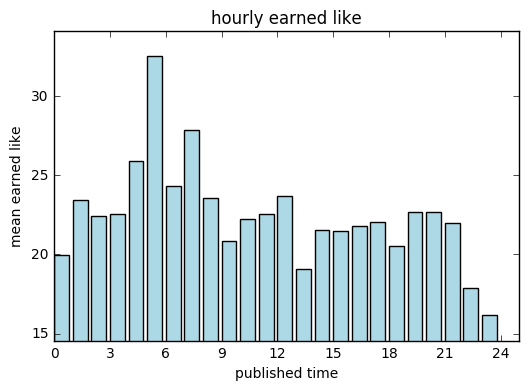

In [266]:
show_graph(weekday_data)


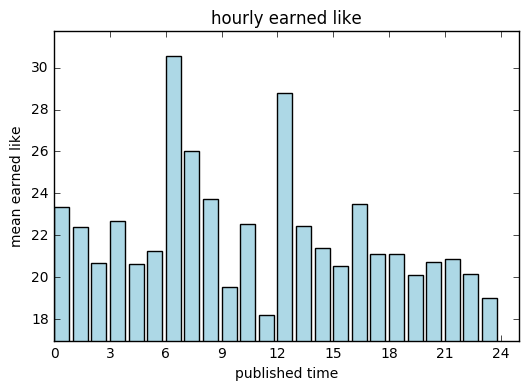

In [267]:
show_graph(holyday_data)